# Lab12-2: Image Captioning

In the last Lab, use a combination of convolutional neural networks to obtain the vectorial representation of images and recurrent neural networks to decode those representations into natural language sentences. 

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from PIL import Image
import pickle
from tensorflow import keras
from tensorflow.keras import Input, layers, Model
from tqdm import tqdm

In [3]:
# Store captions and image names in vectors
all_captions = []
all_img_name_vector = [] # 140000 images

with open('./words_captcha/spec_train_val.txt') as f:
    for line in f:
        img_name, caption = line.strip().split()
        all_img_name_vector.append(f'./words_captcha/{img_name}.png')
        all_captions.append('<start> ' + ' '.join(caption) + ' <end>')
        
for i in range(120000, 140000):
    all_img_name_vector.append(f'./words_captcha/a{i}.png')
    
print(len(all_img_name_vector)) # 140000
print(all_img_name_vector[0])
print(all_captions[0])

140000
./words_captcha/a0.png
<start> t h u s <end>


## Preprocess and tokenize the captions

In [4]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [5]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_captions)

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(all_captions)

print(all_captions[0])
print(train_seqs[0])

<start> t h u s <end>
[2, 9, 18, 17, 6, 3]


In [6]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [7]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
print(cap_vector[0])

[ 2  9 18 17  6  3  0]


In [8]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
print(max_length)

7


## Split the data into training and testing

In [9]:
# Shuffle captions and image_names together
# Set a random state
# img_name_train, caption_train = shuffle(all_img_name_vector[:100000], cap_vector[:100000], random_state=514)
# img_name_valid, caption_valid = shuffle(all_img_name_vector[100000:120000], cap_vector[100000:120000], random_state=514)

img_name_train, cap_train = all_img_name_vector[:100000], cap_vector[:100000]
img_name_valid, cap_val = all_img_name_vector[100000:120000], cap_vector[100000:120000]

img_name_test = all_img_name_vector[120000:]

## Create a tf.data dataset for training

In [10]:
BATCH_SIZE = 100
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE

In [11]:
IMAGE_SIZE = (200, 300)

def load_image(image_path, cap):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255 * 2 - 1
    # img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, cap

In [12]:
dataset_train = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))\
                               .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .shuffle(BUFFER_SIZE)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_valid = tf.data.Dataset.from_tensor_slices((img_name_valid, cap_val))\
                               .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [13]:
for img, cap in dataset_valid.take(1):
    # 印第一個pair的info
    print("Image shape:", img.shape)
    print("Caption:", cap[0].numpy())

Image shape: (100, 200, 300, 3)
Caption: [ 2 14  8  7  3  0  0]


## Model

In [14]:
# image_model = tf.keras.applications.InceptionV3(include_top=False,
#                                                 weights='imagenet')
# new_input = image_model.input
# hidden_layer = image_model.layers[-1].output

# image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [15]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [16]:
img_inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = conv_leaky_relu(img_inputs, 64, 7, 2)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 192, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 128, 1, 1)
x = conv_leaky_relu(x, 256, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

YOLO = keras.Model(inputs=img_inputs, outputs=x, name="YOLO")

YOLO.summary()

Model: "YOLO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 150, 64)      9472      
                                                                 
 batch_normalization (BatchN  (None, 100, 150, 64)     256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100, 150, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 75, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 75, 192)       110784 

 leaky_re_lu_15 (LeakyReLU)  (None, 12, 18, 1024)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 9, 1024)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 6, 9, 512)         524800    
                                                                 
 batch_normalization_16 (Bat  (None, 6, 9, 512)        2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 6, 9, 512)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 6, 9, 1024)        4719616   
                                                                 
 batch_normalization_17 (Bat  (None, 6, 9, 1024)       4096      
 chNormali

In [17]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 15, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 10, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 15, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [18]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 15, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [19]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [20]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [21]:
LEARNING_RATE = 1e-4

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoint

In [22]:
checkpoint_path = './checkpoints/YOLO/'
ckpt = tf.train.Checkpoint(feature_extractor = YOLO,
                           encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [23]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [24]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [25]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=img_tensor.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * img_tensor.shape[0], 1)

    with tf.GradientTape() as tape:
        
        features = YOLO(img_tensor, training=True)
        
        # extract the features from YOLO giving us a vector of shape (batch, 3, 5, 1024)
        # squash that to a shape of (batch, 10, 1024)
        features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
        
        features = encoder(features)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            # target[:, i]: 取得目標序列（target）在時間步 i 的實際目標值
            # 將這個實際目標值轉換為形狀為 (batch_size, 1)，表示模型當前時間i+1的輸入(or i的輸出)
            dec_input = tf.expand_dims(target[:, i], 1) 

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = YOLO.trainable_variables + encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [26]:
def predict(img_tensor):
    img_tensor = img_tensor.numpy()
    batch_size = img_tensor.shape[0]
    # 重置decoder的初始狀態
    hidden = decoder.reset_state(batch_size=batch_size)
    
    # 建一個(batch_size, 1)的二維tensor，其中每個元素都是<start>對應的索引(也就是2)
    # 二維的原因: 第一維表示time step，第二維表示batch size
    # 當作decoder的初始輸入，用於生成描述圖像的第一個單字。
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)
    
    # 儲存預測的單字索引
    # shape:(batch_size, time_steps)
    result = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)
    
    # Extract圖片特徵
    features = YOLO(img_tensor)
    features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
    features = encoder(features)
    
    for i in range(max_length):
        # decoder生成預測
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        # 選擇機率最高的預測單字的索引，返回(batch_size,)的tensor
        predicted_id = tf.argmax(predictions, axis=1).numpy() 
        # predicted_id = tf.argmax(predictions[0]).numpy() # 在第一個timestep預測機率最高的單字跟上一行不同
        
        # 更新decoder input，準備下一個timestep的輸入
        dec_input = tf.expand_dims(predicted_id, 1)

        # 將預測結果加入result(batch_size, time_steps)
        result = tf.concat([result, predicted_id.reshape((batch_size, 1))], axis=1)

    return result

In [27]:
def batch_caps_vector_to_word(caps):
    '''
    將單字的索引轉換為原本的單字
    '''
    caps = caps.numpy()
    capword_list = []
    for cap in caps: 
        capword = ''
        for token_num in cap[1:]: #去掉<start>
            if token_num == tokenizer.word_index['<end>']:
                break
            capword += tokenizer.index_word[token_num] # 9 -> t
        capword_list.append(capword)
    return capword_list

In [28]:
def evaluate(dataset_valid):
    correct = 0
    cnt = 0
    for imgs, caps in dataset_valid:
        prediction_list = batch_caps_vector_to_word(predict(imgs))
        ground_truth_list = batch_caps_vector_to_word(caps)
        for i, _ in enumerate(prediction_list):
            cnt += 1
            if prediction_list[i] == ground_truth_list[i]:
                correct += 1

    return correct / cnt

In [29]:
EPOCHS = 20
start = time.time()
for epoch in range(start_epoch, EPOCHS):
    
    total_loss = 0

    pbar = tqdm(dataset_train, total=num_steps, desc=f'Epoch {epoch + 1:2d}')
    
    for (batch, (img_tensor, target)) in enumerate(pbar):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

#         if batch % 100 == 0:
#             print ('Epoch {} Batch {} Loss {:.4f}'.format(
#               epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    ckpt_manager.save()
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    
    score = evaluate(dataset_valid)
    print(f'Valid acc: {score:.2f}')
    
print ('Time taken for {} epoch {} sec\n'.format(EPOCHS - start_epoch, time.time() - start))

Epoch  1: 100%|██████████| 1000/1000 [05:50<00:00,  2.85it/s]


Epoch 1 Loss 1.333528
Valid acc: 0.07


Epoch  2: 100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


Epoch 2 Loss 0.248810
Valid acc: 0.74


Epoch  3: 100%|██████████| 1000/1000 [05:16<00:00,  3.15it/s]


Epoch 3 Loss 0.061757
Valid acc: 0.83


Epoch  4: 100%|██████████| 1000/1000 [04:50<00:00,  3.45it/s]


Epoch 4 Loss 0.028782
Valid acc: 0.83


Epoch  5: 100%|██████████| 1000/1000 [04:49<00:00,  3.45it/s]


Epoch 5 Loss 0.028599
Valid acc: 0.90


Epoch  6: 100%|██████████| 1000/1000 [04:49<00:00,  3.45it/s]


Epoch 6 Loss 0.014117
Valid acc: 0.95


Epoch  7: 100%|██████████| 1000/1000 [04:49<00:00,  3.45it/s]


Epoch 7 Loss 0.016998
Valid acc: 0.80


Epoch  8: 100%|██████████| 1000/1000 [04:49<00:00,  3.45it/s]


Epoch 8 Loss 0.010945
Valid acc: 0.95


Epoch  9: 100%|██████████| 1000/1000 [04:49<00:00,  3.45it/s]


Epoch 9 Loss 0.011986
Valid acc: 0.97


Epoch 10: 100%|██████████| 1000/1000 [05:01<00:00,  3.32it/s]


Epoch 10 Loss 0.013844
Valid acc: 0.73


Epoch 11: 100%|██████████| 1000/1000 [05:24<00:00,  3.08it/s]


Epoch 11 Loss 0.007716
Valid acc: 0.97


Epoch 12: 100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]


Epoch 12 Loss 0.009331
Valid acc: 0.97


Epoch 13: 100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


Epoch 13 Loss 0.005908
Valid acc: 0.87


Epoch 14: 100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


Epoch 14 Loss 0.006485
Valid acc: 0.97


Epoch 15: 100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


Epoch 15 Loss 0.007891
Valid acc: 0.00


Epoch 16: 100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


Epoch 16 Loss 0.004958
Valid acc: 0.96


Epoch 17: 100%|██████████| 1000/1000 [05:01<00:00,  3.32it/s]


Epoch 17 Loss 0.006772
Valid acc: 0.98


Epoch 18: 100%|██████████| 1000/1000 [05:35<00:00,  2.98it/s]


Epoch 18 Loss 0.003774
Valid acc: 0.99


Epoch 19: 100%|██████████| 1000/1000 [05:04<00:00,  3.28it/s]


Epoch 19 Loss 0.004525
Valid acc: 0.98


Epoch 20: 100%|██████████| 1000/1000 [05:23<00:00,  3.09it/s]


Epoch 20 Loss 0.004953
Valid acc: 0.98
Time taken for 20 epoch 6908.685414552689 sec



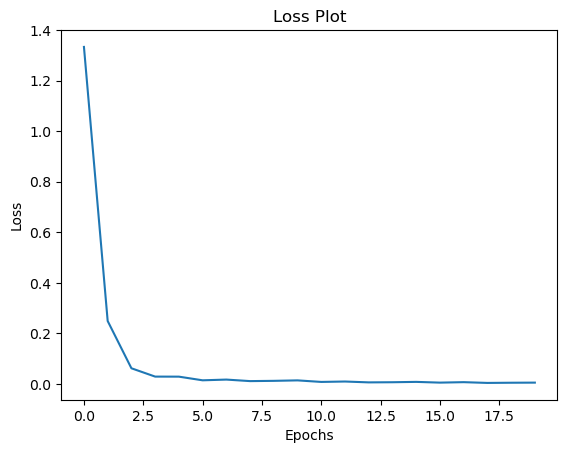

In [30]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Predict dataset_test(img_name_test)

In [31]:
ckpt = tf.train.Checkpoint(feature_extractor=YOLO,
                           encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt.restore('./checkpoints/YOLO/ckpt-20')

In [32]:
score = evaluate(dataset_valid)
print(f'Valid acc: {score:.2f}')

Valid acc: 0.98


In [33]:
def read_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [34]:
dataset_test = tf.data.Dataset.from_tensor_slices((img_name_test))\
                              .map(read_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                              .batch(BATCH_SIZE)\
                              .prefetch(tf.data.experimental.AUTOTUNE)

In [35]:
output_file = './Lab12-2_110062619.txt'

with open(output_file, 'w') as f:
    for step, (img_tensor, img_path) in enumerate(tqdm(dataset_test)):
        prediction_list = batch_caps_vector_to_word(predict(img_tensor))
        for idx, path in enumerate(img_path):
            path = path.numpy().decode('utf-8')
            name_without_extension = os.path.splitext(os.path.basename(path))[0]
            f.write(f'{name_without_extension} {prediction_list[idx]}\n')

100%|██████████| 200/200 [00:46<00:00,  4.31it/s]
